In [53]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


C:\Users\USER\anaconda3\envs\classifier\lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['e', 'cov', 'psd', 'dtype']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import numpy as np

import scipy.io
import scipy.signal 

from matplotlib import mlab
import matplotlib.pyplot as plt


In [3]:
def psd(trials):
    
    ntrials = trials.shape[2]
    trials_PSD = np.zeros((nchannels, 101, ntrials))

    # Iterate over trials and channels
    for trial in range(ntrials):
        for ch in range(nchannels):
            # Calculate the PSD
            (PSD, freqs) = mlab.psd(trials[ch,:,trial], NFFT=int(nsamples), Fs=sample_rate)
            trials_PSD[ch, :, trial] = PSD.ravel()
                
    return trials_PSD, freqs


def plot_psd(trials_PSD, freqs, chan_ind, chan_lab=None, maxy=None):
    plt.figure(figsize=(12,5))
    
    nchans = len(chan_ind)
    
    # Maximum of 3 plots per row
    nrows = int(np.ceil(nchans / 3))
    ncols = min(3, nchans)
    
    # Enumerate over the channels
    for i,ch in enumerate(chan_ind):
        # Figure out which subplot to draw to
        plt.subplot(nrows,ncols,i+1)
    
        # Plot the PSD for each class
        for cl in trials.keys():
            plt.plot(freqs, np.mean(trials_PSD[cl][ch,:,:], axis=1), label=cl)
    
        # All plot decoration below...
        
        plt.xlim(1,30)
        
        if maxy != None:
            plt.ylim(0,maxy)
    
        plt.grid()
    
        plt.xlabel('Frequency (Hz)')
        
        if chan_lab == None:
            plt.title('Channel %d' % (ch+1))
        else:
            plt.title(chan_lab[i])

        plt.legend()
        
    plt.tight_layout()

def bandpass(trials, lo, hi, sample_rate):
 
    a, b = scipy.signal.iirfilter(6, [lo/(sample_rate/2.0), hi/(sample_rate/2.0)])

    ntrials = trials.shape[2]
    trials_filt = np.zeros((nchannels, nsamples, ntrials))
    for i in range(ntrials):
        trials_filt[:,:,i] = scipy.signal.filtfilt(a, b, trials[:,:,i], axis=1)
    
    return trials_filt

def logvar(trials):
    return np.var(trials, axis=1)

def plot_logvar(trials, trial_no = None):
    plt.figure(figsize=(12,5))

    print(trials[cl1].shape)
    
    x0 = np.arange(nchannels)
    x1 = np.arange(nchannels) + 0.4

    if trial_no == None:
        y0 = np.mean(trials[cl1], axis=1)
        y1 = np.mean(trials[cl2], axis=1)
    else:
        y0 = trials[cl1][:,trial_no]
        y1 = trials[cl2][:,trial_no]

    plt.bar(x0, y0, width=0.5, color='b')
    plt.bar(x1, y1, width=0.4, color='r')

    plt.xlim(-0.5, nchannels+0.5)

    plt.gca().yaxis.grid(True)
    plt.title('log-var of each channel/component')
    plt.xlabel('channels/components')
    plt.ylabel('log-var')
    plt.legend(cl_lab)

from numpy import linalg

def cov(trials):
    ntrials = trials.shape[2]
    covs = [ trials[:,:,i].dot(trials[:,:,i].T) / nsamples for i in range(ntrials) ]
    return np.mean(covs, axis=0)

def whitening(sigma):
    U, l, _ = linalg.svd(sigma)
    return U.dot( np.diag(l ** -0.5) )

def csp(trials_r, trials_f):
    cov_r = cov(trials_r)
    cov_f = cov(trials_f)
    P = whitening(cov_r + cov_f)
    B, _, _ = linalg.svd( P.T.dot(cov_f).dot(P) )
    W = P.dot(B)
    return W

def apply_mix(W, trials):
    ntrials = trials.shape[2]
    trials_csp = np.zeros((nchannels, nsamples, ntrials))
    for i in range(ntrials):
        trials_csp[:,:,i] = W.T.dot(trials[:,:,i])
    return trials_csp

import torch
import snntorch.spikeplot as splt
from snntorch import spikegen

def spike_latency(trials, trial_n, cls, num_steps):
    input_data = trials[cl1] if cls == 1 else trials[cl2]
    
    tensor = torch.tensor(input_data[:,trial_n])
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tensor = tensor.to(device)
    
    spike_data = spikegen.latency(tensor, num_steps=num_steps, threshold=(np.mean(input_data[:,trial_n])+1)*1/2, bypass=True)

    return spike_data

def spike_rate(trials, trial_n, cls, num_steps):
    input_data = trials[cl1] if cls == 1 else trials[cl2]
    
    tensor = torch.tensor(input_data[:,trial_n])
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tensor = tensor.to(device)
    
    spike_data = spikegen.rate(tensor, num_steps=num_steps)

    return spike_data

def plot_raster(spike_data):
    
    fig = plt.figure(facecolor="w", figsize=(10, 5))
    ax = fig.add_subplot(111)
    
    spike_data_sample = spike_data
    splt.raster(spike_data_sample, ax, s=1.5, c="black")
    plt.ylim(0, 60)
    
    plt.title("Input Layer")
    plt.xlabel("Time step")
    plt.ylabel("Neuron Number")
    plt.show()

def plot_snn_spikes(spk_in, spk1_rec, spk2_rec, num_steps, title):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,7), sharex=True, 
                        gridspec_kw = {'height_ratios': [1, 1, 0.4]})

  # Plot input spikes
  splt.raster(spk_in[:,0], ax[0], s=0.1, c="black")
  ax[0].set_ylabel("Input Spikes")
  ax[0].set_title(title)

  # Plot hidden layer spikes
  splt.raster(spk1_rec.reshape(num_steps, -1), ax[1], s = 0.1, c="black")
  ax[1].set_ylabel("Hidden Layer")

  # Plot output spikes
  splt.raster(spk2_rec.reshape(num_steps, -1), ax[2], c="black", marker="|")
  ax[2].set_ylabel("Output Spikes")
  ax[2].set_ylim([0, 10])

  plt.show()

def plot_snn_spikes(spk_in, spk1_rec, spk2_rec, num_steps, title):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,7), sharex=True, 
                        gridspec_kw = {'height_ratios': [1, 1, 0.4]})

  # Plot input spikes
  splt.raster(spk_in[:,0], ax[0], s=0.1, c="black")
  ax[0].set_ylabel("Input Spikes")
  ax[0].set_title(title)

  # Plot hidden layer spikes
  splt.raster(spk1_rec.reshape(num_steps, -1), ax[1], s = 0.1, c="black")
  ax[1].set_ylabel("Hidden Layer")

  # Plot output spikes
  splt.raster(spk2_rec.reshape(num_steps, -1), ax[2], c="black", marker="|")
  ax[2].set_ylabel("Output Spikes")
  ax[2].set_yticks([0, 1], ['left', 'right'])
  ax[2].set_ylim([-0.5, 1.5])


  plt.show()

def plot_snn_spikes_modified1(spk_in, spk1_rec, spk2_rec, spk3_rec, num_steps, title):
  # Generate Plots
  fig, ax = plt.subplots(4, figsize=(8,7), sharex=True, 
                        gridspec_kw = {'height_ratios': [1, 1, 0.4, 0.4]})

  # Plot input spikes
  splt.raster(spk_in[:,0], ax[0], s=0.1, c="black")
  ax[0].set_ylabel("Input Spikes")
  ax[0].set_title(title)

  # Plot hidden layer spikes
  splt.raster(spk1_rec.reshape(num_steps, -1), ax[1], s = 0.1, c="black")
  ax[1].set_ylabel("Hidden Layer")

  # Plot output spikes
  splt.raster(spk2_rec.reshape(num_steps, -1), ax[2], c="black", marker="|")
  ax[2].set_ylabel("Output Spikes")
  ax[2].set_yticks([0, 1], ['left', 'right'])
  ax[2].set_ylim([-0.5, 1.5])

  # Plot output spikes
  splt.raster(spk3_rec.reshape(num_steps, -1), ax[3], c="black", marker="|")
  ax[3].set_ylabel("Output Spikes")
  ax[3].set_yticks([0, 1], ['left', 'right'])
  ax[3].set_ylim([-0.5, 1.5])


  plt.show()

def plot_snn_spikes_modified(spk_in, spk1_rec, spk2_rec, num_steps, title):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,7), sharex=False, 
                        gridspec_kw = {'height_ratios': [1, 1, 0.4]})

  # Plot input spikes

  neuron_numbers = list(range(59))
  currents = spk_in.tolist()  # Currents fed to each neuron
    
  # Create bar chart
  ax[0].bar(neuron_numbers, currents, color='skyblue')
  ax[0].set_ylabel("Input Currents")
  ax[0].set_title(title)

  # Plot hidden layer spikes
  splt.raster(spk1_rec.reshape(num_steps, -1), ax[1], s = 0.1, c="black")
  ax[1].set_ylabel("Hidden Layer")

  # Plot output spikes
  splt.raster(spk2_rec.reshape(num_steps, -1), ax[2], c="black", marker="|")
  ax[2].set_ylabel("Output Spikes")
  ax[2].set_yticks([0, 1], ['left', 'right'])
  ax[2].set_ylim([-0.5, 1.5])


  plt.show()

In [4]:
def normalize_signals(signals):
    """Normalize each signal to have a mean of 0 and std of 1."""
    normalized_signals = []
    for signal in signals:
        mean = np.mean(signal)
        std = np.std(signal)
        normalized_signal = (signal - mean) / std
        normalized_signals.append(normalized_signal)
    return normalized_signals

In [5]:
def normalize_signals(signals):
    """Normalize each signal to have a mean of 0 and std of 1."""
    normalized_signals = []
    mean = np.mean(signals)
    std = np.std(signals)
    for signal in signals:
        normalized_signal = (signal - mean) / std
        normalized_signals.append(normalized_signal)
    return normalized_signals

In [6]:
def normalize_signals_to_0_and_1(signals):
    """Normalize each signal to have values mapped between 0 and 1."""
    normalized_signals = []
    for signal in signals:
        min_val = np.min(signals)
        max_val = np.max(signals)
        # Avoid division by zero in case all values in the signal are the same
        if max_val - min_val == 0:
            # If all values are the same, the normalized signal will have all values as 0.
            # Alternatively, you could set them all to 0.5 to represent the mid-point.
            normalized_signal = np.zeros_like(signal)
        else:
            normalized_signal = (signal - min_val) / (max_val - min_val)
        normalized_signals.append(normalized_signal)
    return normalized_signals

In [7]:
m = scipy.io.loadmat('BCICIV_1_mat\BCICIV_calib_ds1d.mat', struct_as_record=True)

sample_rate = m['nfo']['fs'][0][0][0][0]
EEG = m['cnt'].T
nchannels, nsamples = EEG.shape

channel_names = [s[0] for s in m['nfo']['clab'][0][0][0]]
event_onsets = m['mrk'][0][0][0]
event_codes = m['mrk'][0][0][1]
labels = np.zeros((1, nsamples), int)
labels[0, event_onsets] = event_codes

cl_lab = [s[0] for s in m['nfo']['classes'][0][0][0]]
cl1 = cl_lab[0]
cl2 = cl_lab[1]
nclasses = len(cl_lab)
nevents = len(event_onsets)

In [8]:
trials = {}

win = np.arange(int(0.5*sample_rate), int(2.5*sample_rate))

nsamples = len(win)

for cl, code in zip(cl_lab, np.unique(event_codes)):
    
    cl_onsets = event_onsets[event_codes == code]

    trials[cl] = np.zeros((nchannels, nsamples, len(cl_onsets)))
    
    for i, onset in enumerate(cl_onsets):
        trials[cl][:,:,i] = EEG[:, win+onset]

In [9]:
trials_filt = {cl1: bandpass(trials[cl1], 2, 30, sample_rate),
               cl2: bandpass(trials[cl2], 2, 30, sample_rate)}

In [10]:
W = csp(trials_filt[cl1], trials_filt[cl2])
trials_csp = {cl1: apply_mix(W, trials_filt[cl1]),
              cl2: apply_mix(W, trials_filt[cl2])}

In [11]:
# Step 1: Concatenate all signals from both classes along the trial dimension
all_signals = np.concatenate([trials_csp[cl1], trials_csp[cl2]], axis=2)  # New shape will be (59, 200, 200)

global_mean = np.min(all_signals)  # A single value for the entire dataset
global_std = np.std(all_signals)    # A single value for the entire dataset

# Step 3: Normalize each class dataset using the global mean and std
normalized_class1_data = (trials_csp[cl1] - global_mean) / global_std
normalized_class2_data = (trials_csp[cl2] - global_mean) / global_std


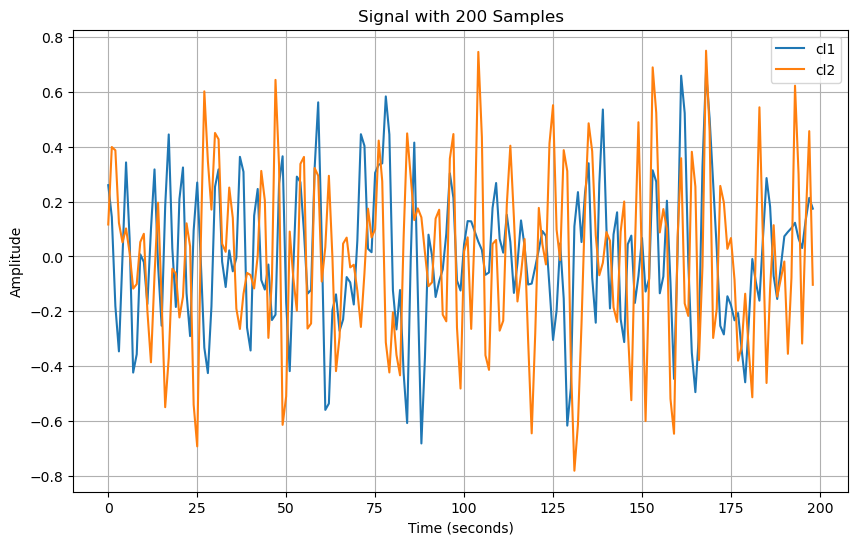

In [12]:
e = 0

diff_signalcl1 = np.diff(trials_csp[cl1][0,:,0])
diff_signalcl2 = np.diff(trials_csp[cl2][0,:,0])
plt.figure(figsize=(10, 6))
plt.plot(diff_signalcl1, label='cl1')
plt.plot(diff_signalcl2, label='cl2')
plt.title('Signal with 200 Samples')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

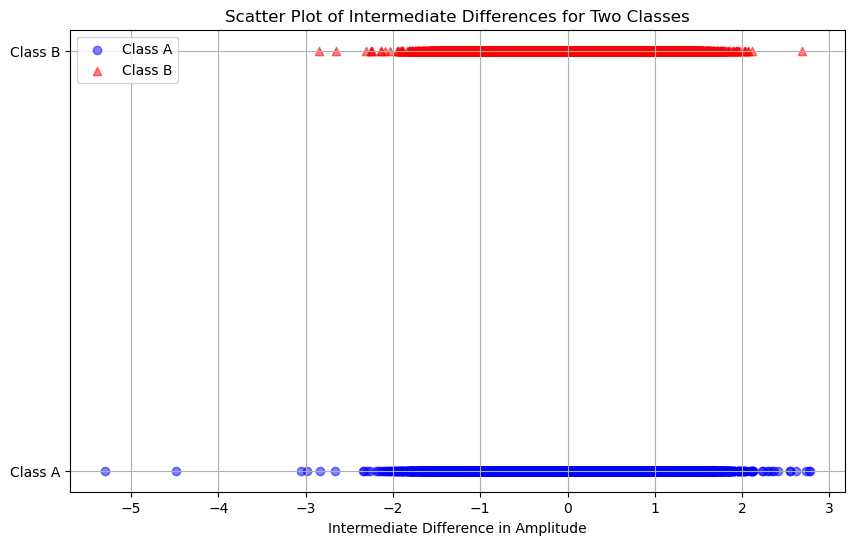

In [13]:
signals_class_A = trials_csp[cl1]
signals_class_B = trials_csp[cl2]

# Calculating intermediate differences
diff_signals_class_A = np.diff(signals_class_A, axis=1)
diff_signals_class_B = np.diff(signals_class_B, axis=1)

# Flattening the arrays to get a single list of differences for each class
diff_flat_A = diff_signals_class_A.flatten()
diff_flat_B = diff_signals_class_B.flatten()

# Creating labels for the classes
labels_A = ['Class A'] * len(diff_flat_A)
labels_B = ['Class B'] * len(diff_flat_B)

# Combining the data for plotting
combined_diff = np.concatenate((diff_flat_A, diff_flat_B))
combined_labels = np.concatenate((labels_A, labels_B))

# Scatter plot
plt.figure(figsize=(10, 6))
for label, marker, color in zip(['Class A', 'Class B'], ['o', '^'], ['blue', 'red']):
    # Using a fixed y-value for each class to remove jitter
    y_value = 0 if label == 'Class A' else 1
    plt.scatter(combined_diff[combined_labels == label], 
                [y_value] * len(combined_diff[combined_labels == label]), 
                label=label, marker=marker, color=color, alpha=0.5)

plt.title('Scatter Plot of Intermediate Differences for Two Classes')
plt.xlabel('Intermediate Difference in Amplitude')
plt.yticks([0, 1], ['Class A', 'Class B'])  # Adjusting y-ticks to show class labels
plt.legend()
plt.grid(True)
plt.show()

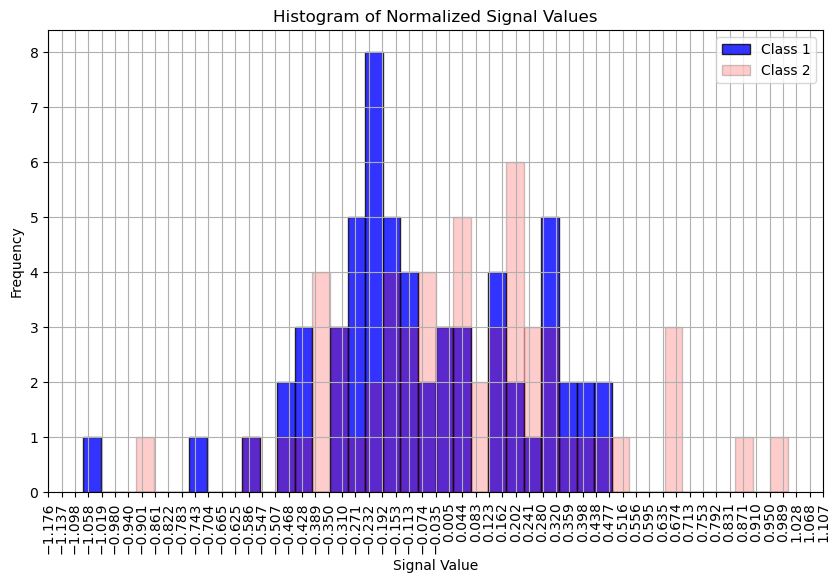

In [14]:
flattened_class1 = trials_csp[cl1][:,1,0].flatten()
flattened_class2 = trials_csp[cl2][:,1,0].flatten()

# Calculate the number of bins based on the combined data
bins = np.histogram(np.hstack((flattened_class1, flattened_class2)), bins=40)[1] # 40 bins

plt.figure(figsize=(10, 6))

# Plotting the histograms side by side for each bin range
plt.hist(flattened_class1, bins, alpha=0.8, label='Class 1', color='blue', edgecolor='black')
plt.hist(flattened_class2, bins, alpha=0.2, label='Class 2', color='red', edgecolor='black')

plt.title('Histogram of Normalized Signal Values')
plt.xlabel('Signal Value')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.grid(True)

xmin, xmax = plt.xlim()  # Get current x-axis limits to cover the full range of your data
x_ticks = np.linspace(xmin, xmax, num=59)  # Generate 20 evenly spaced ticks within this range
plt.xticks(x_ticks, rotation='vertical')

plt.show()

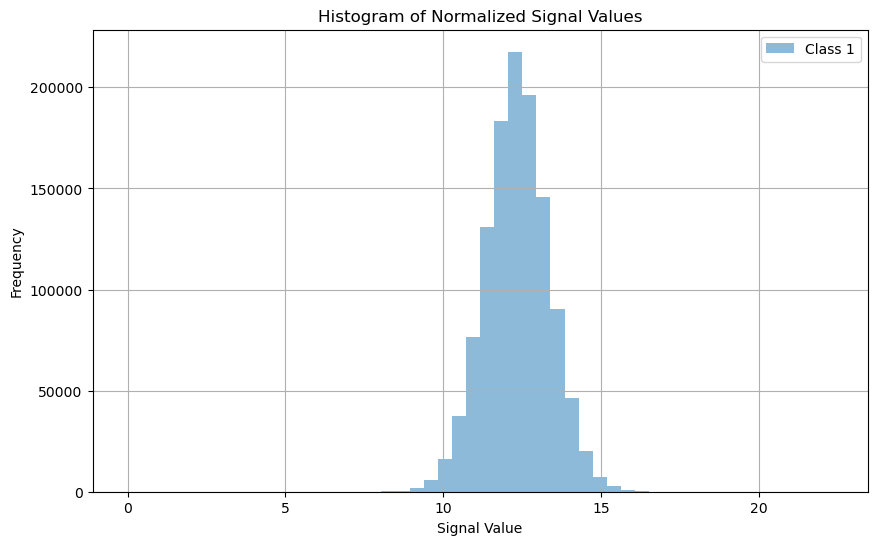

In [15]:
flattened_class1 = normalized_class1_data.flatten()
flattened_class2 = normalized_class2_data.flatten()

# Create the histogram plot
plt.figure(figsize=(10, 6))
plt.hist(flattened_class1, bins=50, alpha=0.5, label='Class 1')
#plt.hist(flattened_class2, bins=50, alpha=0.5, label='Class 2')
plt.title('Histogram of Normalized Signal Values')
plt.xlabel('Signal Value')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [16]:
normalized_trials = {cl1: trials_csp[cl1], cl2: trials_csp[cl2]}

In [17]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        if len(self.data.shape) > 1:
            return self.data.shape[2]
        else:
            return 1

    def __getitem__(self, idx):
        sample = self.data[:,1:,idx]
        label = self.data[0,0,idx]
        return torch.tensor(sample, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

In [18]:
data = normalized_trials

# Additional column for class identifiers
class_column_left = np.zeros((59, 1, 100))  # Assuming all instances belong to class 0
class_column_right = np.ones((59, 1, 100))  # Assuming all instances belong to class 1

# Concatenate class column along with left and right arrays
left_with_class = np.concatenate([class_column_left, data['left']], axis=1)
right_with_class = np.concatenate([class_column_right, data['right']], axis=1)

# Concatenate left and right arrays along axis 1
result = np.concatenate([left_with_class, right_with_class], axis=2)

In [19]:
cl1_split_idx = int(result.shape[2]*0.5*0.8)
cl2_split_idx = int(result.shape[2]*0.5*1.8)

train_data = np.concatenate([result[:, :, :cl1_split_idx],result[:, :, 100:cl2_split_idx]], axis=2)
test_data = np.concatenate([result[:, :, cl1_split_idx:100],result[:, :, cl2_split_idx:]], axis=2)

# Create CustomDataset instance
train_dataset = CustomDataset(train_data)
test_dataset = CustomDataset(test_data)

# Create DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

for samples, labels in train_loader:
    # Your training code here
    print(samples.shape, labels[0])

torch.Size([32, 59, 200]) tensor(1)
torch.Size([32, 59, 200]) tensor(1)
torch.Size([32, 59, 200]) tensor(0)
torch.Size([32, 59, 200]) tensor(1)
torch.Size([32, 59, 200]) tensor(1)


C:\Users\USER\AppData\Local\Temp\ipykernel_18744\2584680384.py:18: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  return torch.tensor(sample, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


In [20]:
dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [64]:
# Define Network
class RSNN(nn.Module):
    def __init__(self):
        super().__init__()

        # hyperparam stuff
        num_inputs = 59
        num_hidden = 200
        num_outputs = 2
        
        beta = 0.9
        self.T1 = 2.0
        #self.T2 = 2.0

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta)

        self.spkIn = []
        self.spk1 = []
        self.spk2 = []
        
    def _delta_coding(self, x):
        tensor = torch.tensor(x)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        tensor = tensor.to(device)
    
        #spike_data1_on = spikegen.delta(x, threshold=self.T1)
        spike_data1_off = spikegen.delta(x, threshold=self.T1, off_spike=True)
    
        #spike_data2_on = spikegen.delta(x, threshold=self.T2)
        #spike_data2_off = spikegen.delta(x, threshold=self.T2, off_spike=True)
    
        #return torch.cat((spike_data1_on, spike_data1_off, spike_data2_on, spike_data2_off), dim=1)
        #return torch.abs(torch.cat((spike_data1_off, spike_data2_off), dim=1))
        return torch.abs(spike_data1_off)

    def forward(self, x):

        self.spkIn = []
        self.spk1 = []
        self.spk2 = []

        # Initialize hidden states at t=0
        spk1, mem1 = self.lif1.init_rleaky()
        spk2, mem2 = self.lif2.init_rleaky()
        
        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        x = self._delta_coding(x)

        for step in range(x.size(2)):  # batch x num_inputs x time
            cur1 = self.fc1(x[:,:,step])
            #print(cur1.shape, spk1.shape, mem1.shape)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)

            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

            self.spkIn.append(x[:,:,step])
            self.spk1.append(spk1)
            self.spk2.append(spk2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

        
# Load the network onto CUDA if available
rnet = RSNN().to(device)

In [65]:
for samples, labels in train_loader:
    spike_data = rnet.forward(samples)
    #spike_data = spikegen.delta(samples, threshold=0.5)

C:\Users\USER\AppData\Local\Temp\ipykernel_18744\2584680384.py:18: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  return torch.tensor(sample, dtype=torch.float32), torch.tensor(label, dtype=torch.long)
C:\Users\USER\AppData\Local\Temp\ipykernel_18744\2450765298.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor = torch.tensor(x)


In [66]:
for samples, labels in train_loader:
    spike_data = rnet.forward(samples)
    #spike_data = spikegen.delta(samples, threshold=0.5)

C:\Users\USER\AppData\Local\Temp\ipykernel_18744\2584680384.py:18: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  return torch.tensor(sample, dtype=torch.float32), torch.tensor(label, dtype=torch.long)
C:\Users\USER\AppData\Local\Temp\ipykernel_18744\2450765298.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor = torch.tensor(x)


In [67]:
def print_batch_accuracy(data, targets, train=False):
    output, _ = rnet(data)
    _, idx = output.sum(dim=0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())

    if train:
        print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
    else:
        print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")

def train_printer(
    data, targets, epoch,
    counter, iter_counter,
        loss_hist, test_loss_hist, test_data, test_targets):
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    print_batch_accuracy(data, targets, train=True)
    print_batch_accuracy(test_data, test_targets, train=False)
    print("\n")

In [68]:
import snntorch.functional as SF

loss = SF.ce_count_loss()
optimizer = torch.optim.Adam(rnet.parameters(), lr=5e-4, betas=(0.9, 0.999))

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [69]:
num_epochs = 20
loss_hist = []
test_loss_hist = []
counter = 0

In [70]:
# Outer training loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        rnet.train()
        spk_rec, mem_rec = rnet(data)

        # initialize the loss & sum over time
        loss_val = loss(spk_rec, targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        with torch.no_grad():
            rnet.eval()
            test_data, test_targets = next(iter(test_loader))
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            # Test set forward pass
            test_spk, test_mem = rnet(test_data)

            # Test set loss
            test_loss = loss(test_spk, test_targets)
            test_loss_hist.append(test_loss.item())

            # Print train/test loss/accuracy
            if counter % 5 == 0:
                train_printer(
                    data, targets, epoch,
                    counter, iter_counter,
                    loss_hist, test_loss_hist,
                    test_data, test_targets)
            counter += 1
            iter_counter +=1

C:\Users\USER\AppData\Local\Temp\ipykernel_18744\2584680384.py:18: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  return torch.tensor(sample, dtype=torch.float32), torch.tensor(label, dtype=torch.long)
C:\Users\USER\AppData\Local\Temp\ipykernel_18744\2450765298.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor = torch.tensor(x)


Epoch 0, Iteration 0
Train Set Loss: 0.71
Test Set Loss: 0.71
Train set accuracy for a single minibatch: 46.88%
Test set accuracy for a single minibatch: 62.50%


Epoch 1, Iteration 0
Train Set Loss: 0.68
Test Set Loss: 0.69
Train set accuracy for a single minibatch: 50.00%
Test set accuracy for a single minibatch: 62.50%


Epoch 2, Iteration 0
Train Set Loss: 0.63
Test Set Loss: 0.69
Train set accuracy for a single minibatch: 46.88%
Test set accuracy for a single minibatch: 62.50%


Epoch 3, Iteration 0
Train Set Loss: 0.66
Test Set Loss: 0.58
Train set accuracy for a single minibatch: 43.75%
Test set accuracy for a single minibatch: 65.62%


Epoch 4, Iteration 0
Train Set Loss: 0.61
Test Set Loss: 0.57
Train set accuracy for a single minibatch: 46.88%
Test set accuracy for a single minibatch: 68.75%


Epoch 5, Iteration 0
Train Set Loss: 0.70
Test Set Loss: 0.44
Train set accuracy for a single minibatch: 56.25%
Test set accuracy for a single minibatch: 78.12%


Epoch 6, Iteration 0
T

KeyboardInterrupt: 

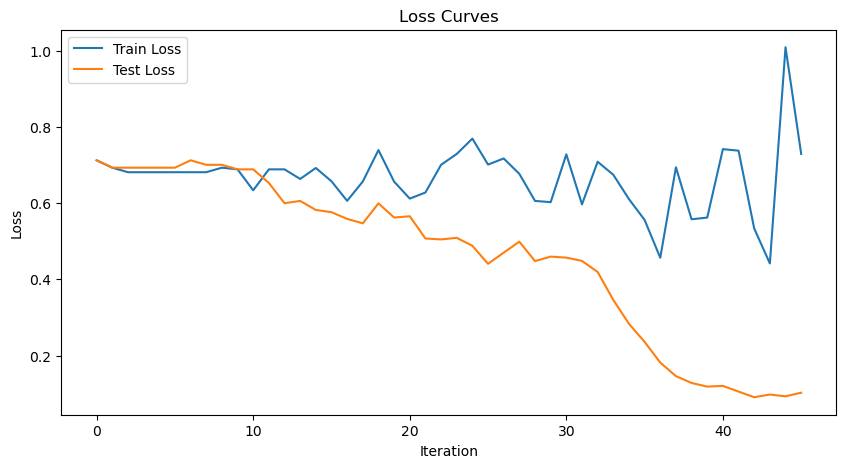

In [71]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.title("Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

C:\Users\USER\AppData\Local\Temp\ipykernel_18744\2584680384.py:18: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  return torch.tensor(sample, dtype=torch.float32), torch.tensor(label, dtype=torch.long)
C:\Users\USER\AppData\Local\Temp\ipykernel_18744\2450765298.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor = torch.tensor(x)


tensor(0)


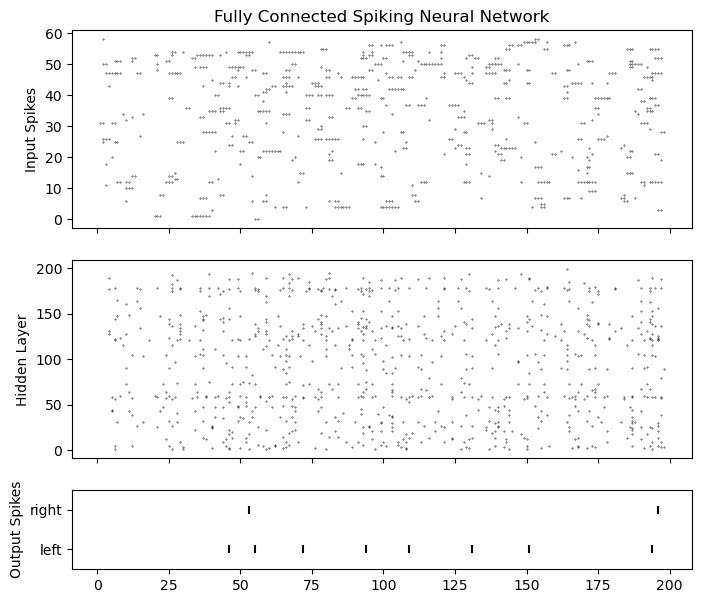

tensor(1)


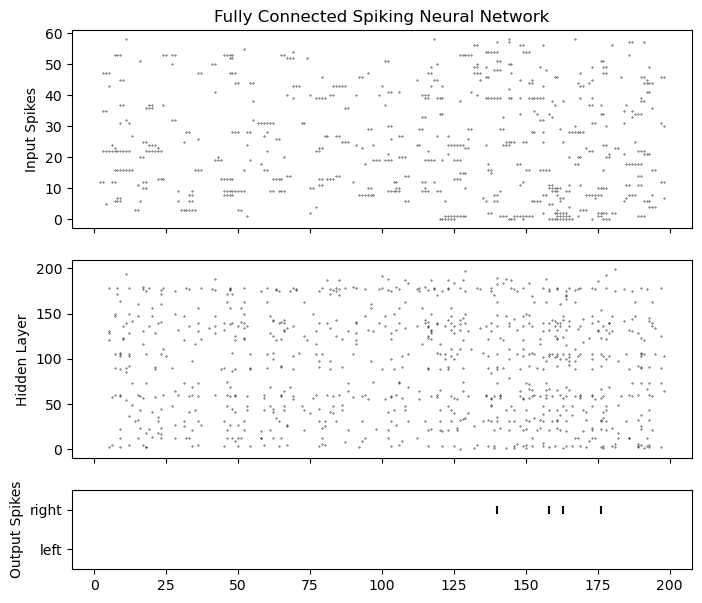

In [52]:
for samples, labels in test_loader:
    i = 3
    print(labels[i])
    output = rnet(samples)
    
    spk_In = torch.stack(rnet.spkIn).unsqueeze(1)
    spk_rec1 = torch.stack(rnet.spk1)
    spk_rec2 = torch.stack(rnet.spk2)
    
    plot_snn_spikes(spk_In[:,:,i,:], spk_rec1[:,i,:], spk_rec2[:,i,:], spk_In[:,:,i,:].shape[0], "Fully Connected Spiking Neural Network")

C:\Users\USER\AppData\Local\Temp\ipykernel_18744\2584680384.py:18: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  return torch.tensor(sample, dtype=torch.float32), torch.tensor(label, dtype=torch.long)
C:\Users\USER\AppData\Local\Temp\ipykernel_18744\2450765298.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor = torch.tensor(x)


tensor(0)


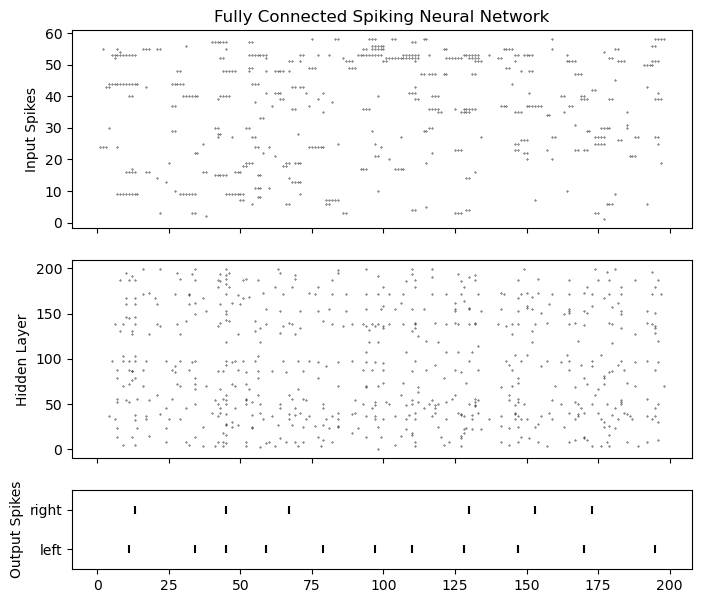

tensor(1)


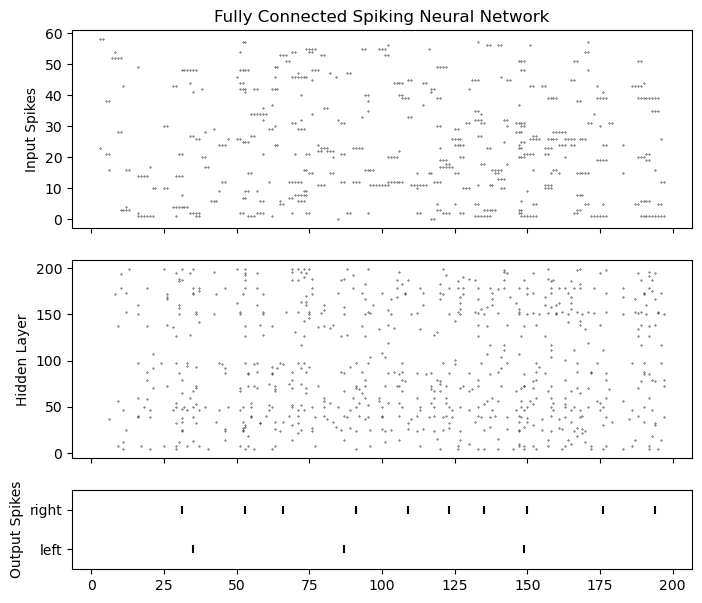

In [39]:
for samples, labels in test_loader:
    i = 7
    print(labels[i])
    output = rnet(samples)
    
    spk_In = torch.stack(rnet.spkIn).unsqueeze(1)
    spk_rec1 = torch.stack(rnet.spk1)
    spk_rec2 = torch.stack(rnet.spk2)
    
    plot_snn_spikes(spk_In[:,:,i,:], spk_rec1[:,i,:], spk_rec2[:,i,:], spk_In[:,:,i,:].shape[0], "Fully Connected Spiking Neural Network")

In [365]:
cl1

'left'

In [42]:
torch.save(rnet.state_dict(), 'Delta_Coding_model_2_time_step.pth')

C:\Users\USER\AppData\Local\Temp\ipykernel_18744\2584680384.py:18: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  return torch.tensor(sample, dtype=torch.float32), torch.tensor(label, dtype=torch.long)
C:\Users\USER\AppData\Local\Temp\ipykernel_18744\2450765298.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor = torch.tensor(x)


tensor(0)


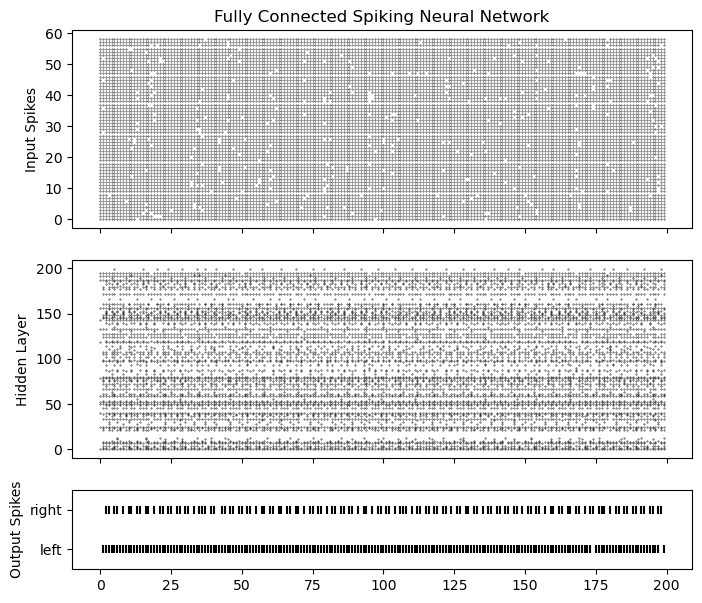

tensor(0)


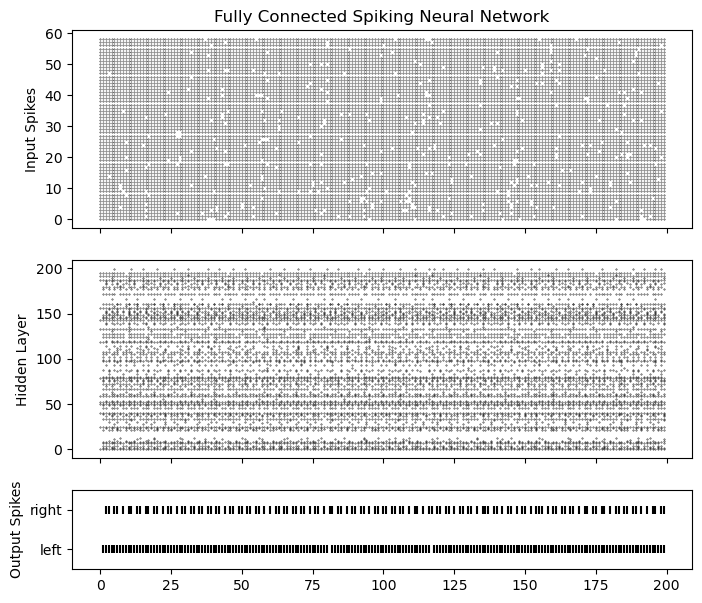

tensor(0)


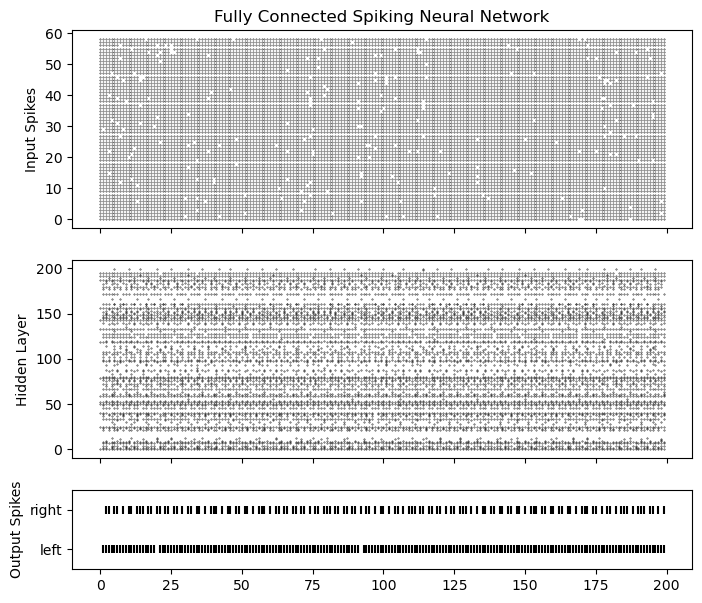

tensor(0)


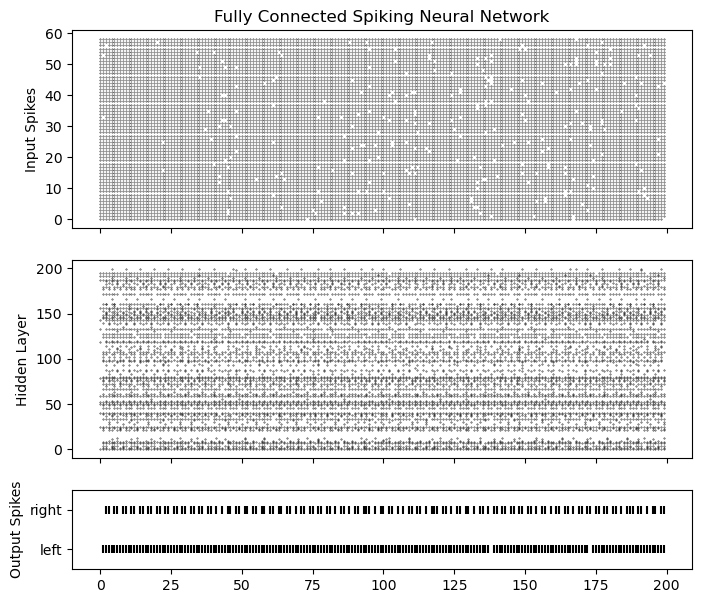

tensor(1)


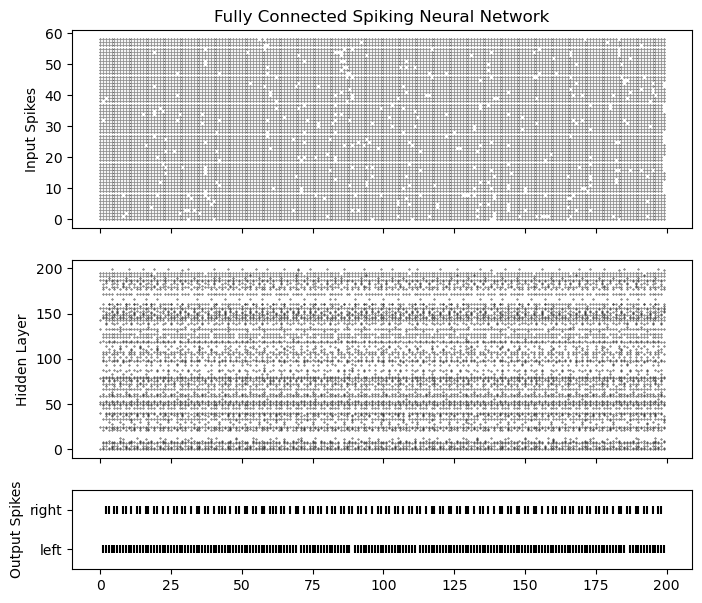

tensor(1)


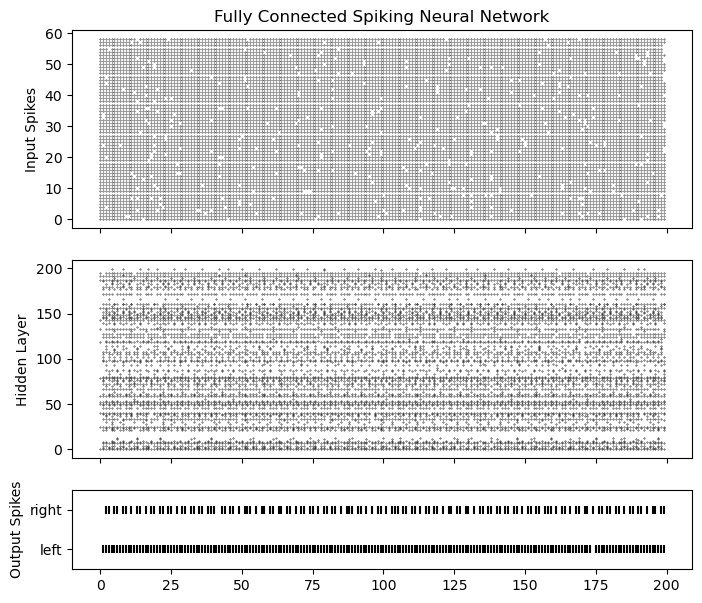

tensor(1)


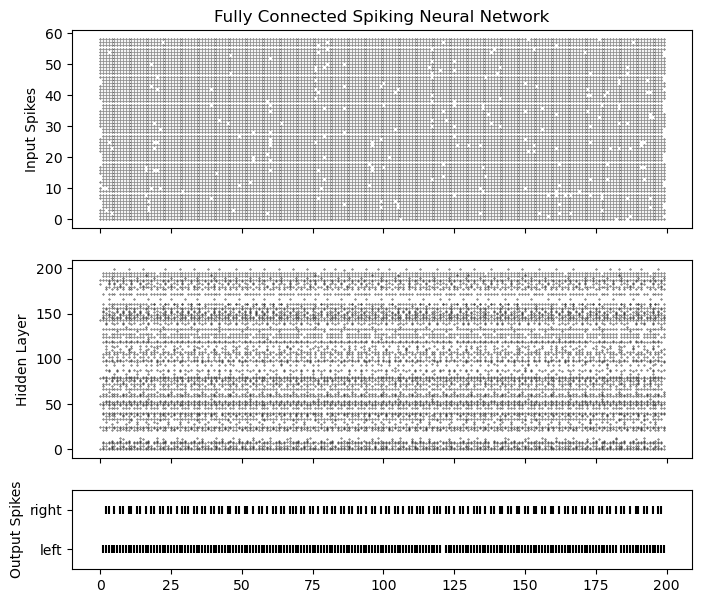

In [41]:
m = scipy.io.loadmat('BCICIV_1_mat\BCICIV_calib_ds1b.mat', struct_as_record=True)

sample_rate = m['nfo']['fs'][0][0][0][0]
EEG = m['cnt'].T
nchannels, nsamples = EEG.shape

channel_names = [s[0] for s in m['nfo']['clab'][0][0][0]]
event_onsets = m['mrk'][0][0][0]
event_codes = m['mrk'][0][0][1]
labels = np.zeros((1, nsamples), int)
labels[0, event_onsets] = event_codes

cl_lab = [s[0] for s in m['nfo']['classes'][0][0][0]]
cl1 = cl_lab[0]
cl2 = cl_lab[1]
nclasses = len(cl_lab)
nevents = len(event_onsets)

trials = {}

win = np.arange(int(0.5*sample_rate), int(2.5*sample_rate))

nsamples = len(win)

for cl, code in zip(cl_lab, np.unique(event_codes)):
    
    cl_onsets = event_onsets[event_codes == code]

    trials[cl] = np.zeros((nchannels, nsamples, len(cl_onsets)))
    
    for i, onset in enumerate(cl_onsets):
        trials[cl][:,:,i] = EEG[:, win+onset]

trials_filt = {cl1: bandpass(trials[cl1], 2, 30, sample_rate),
               cl2: bandpass(trials[cl2], 2, 30, sample_rate)}

# Step 1: Concatenate all signals from both classes along the trial dimension
#all_signals = np.concatenate([trials_filt[cl1], trials_filt[cl1]], axis=2)  # New shape will be (59, 200, 200)

#global_mean = np.mean(all_signals)  # A single value for the entire dataset
#global_std = np.std(all_signals)    # A single value for the entire dataset

# Step 3: Normalize each class dataset using the global mean and std
normalized_class1_data = (trials_filt[cl1] - global_mean) / global_std
normalized_class2_data = (trials_filt[cl2] - global_mean) / global_std

normalized_trials = {cl1: normalized_class1_data, cl2: normalized_class2_data}

data = normalized_trials

# Additional column for class identifiers
class_column_left = np.zeros((59, 1, 100))  # Assuming all instances belong to class 0
class_column_right = np.ones((59, 1, 100))  # Assuming all instances belong to class 0

# Concatenate class column along with left and right arrays
left_with_class = np.concatenate([class_column_left, data['left']], axis=1)
right_with_class = np.concatenate([class_column_right, data['right']], axis=1)

# Concatenate left and right arrays along axis 1
result = np.concatenate([left_with_class, right_with_class], axis=2)

b_dataset = CustomDataset(result)

batch_size = 32
validation_b_loader = DataLoader(b_dataset, batch_size=batch_size, shuffle=False)

for samples, labels in validation_b_loader:
    i = 0
    print(labels[i])
    output = rnet(samples)
    
    spk_In = torch.stack(rnet.spkIn).unsqueeze(1)
    spk_rec1 = torch.stack(rnet.spk1)
    spk_rec2 = torch.stack(rnet.spk2)
    
    plot_snn_spikes(spk_In[:,:,i,:], spk_rec1[:,i,:], spk_rec2, spk_In[:,:,i,:].shape[0], "Fully Connected Spiking Neural Network")

In [146]:
np.max(normalized_class1_data)

5.069257469392149